In [1]:
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import collections

In [2]:
import tcri

/Users/ceglian/Codebase/tcri/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [33]:
adata = sc.read("/Users/ceglian/Analysis/yost/yost_v2.h5ad")
ct = []
for x in adata.obs["response"]:
    if "yes" in x.lower():
        ct.append("R")
    else:
        ct.append("NR")
adata.obs["response"] = ct

#adata = adata[adata.obs["disease"] == "scc"]

ct = []
for x in adata.obs["cluster"]:
    if "CD8" not in x:
        x = "CD4_{}".format(x)
    if "naive" in x.lower():
        x = "Naive"
    ct.append(x)
adata.obs["phenotype"] = ct
adata.X = csr_matrix(adata.X)
#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)

In [34]:
tcri.pp.add_tcr_key(adata,"trb")

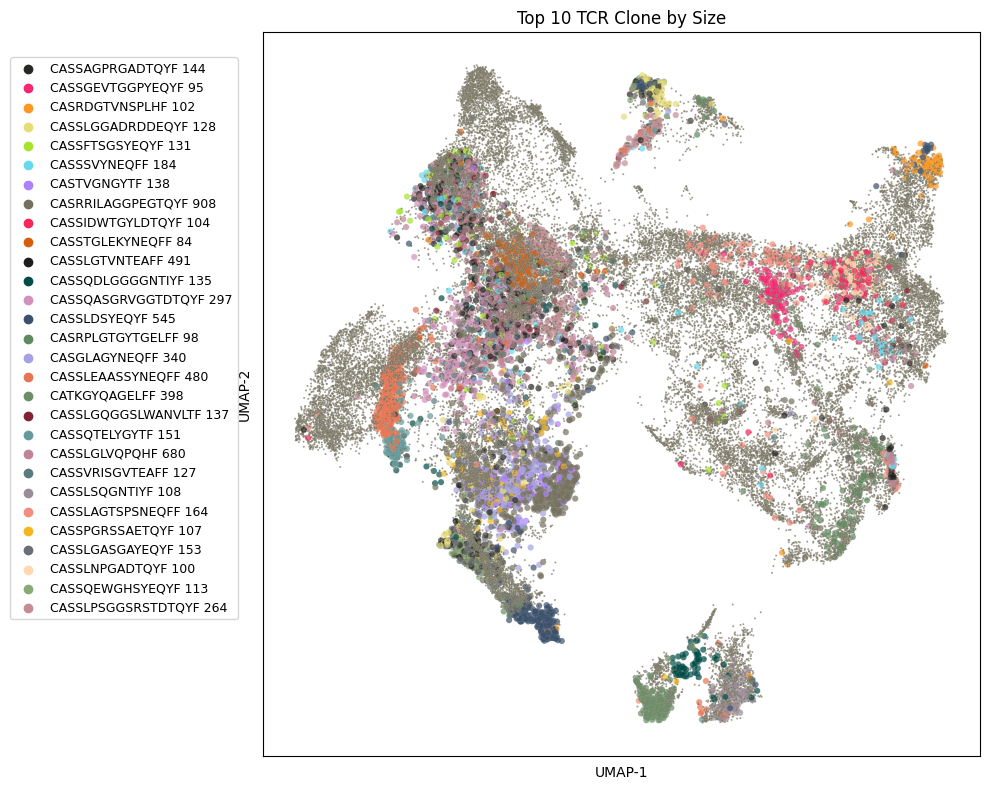

In [35]:
tcri.pl.tcr_umap(adata,top_n=30,size=20)

<AxesSubplot: xlabel='UMAP-1', ylabel='UMAP-2'>

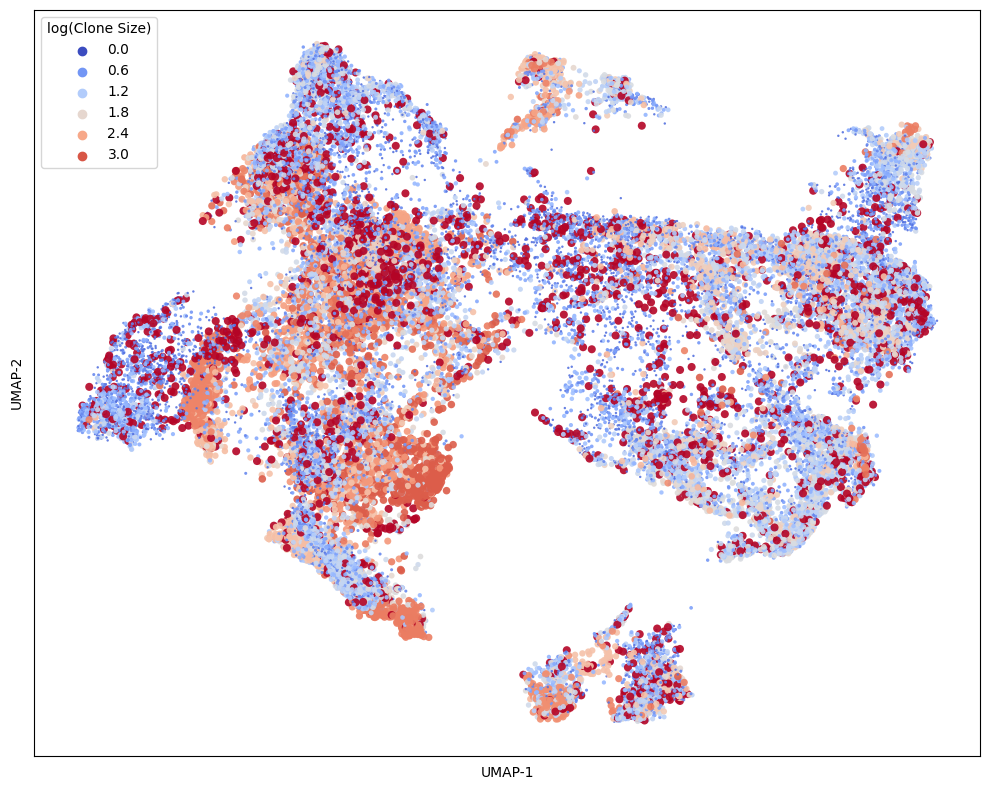

In [36]:
tcri.pl.clone_size(adata,scale=10,alpha=0.9)

In [37]:
tcri.pp.gene_entropy(adata)
# adata = adata[:,adata.var["entropy"] > 0.5]
# adata

100%|██████████| 2000/2000 [00:02<00:00, 994.49it/s] 


In [38]:
tcri.pp.joint_distribution(adata)

In [39]:
markers = dict()
markers['Naive'] = ["IL7R",'TCF7','LEF1','SELL']
markers['Cytotoxic'] = ["GNLY",'GZMB','PRF1','NKG7',"GZMA",'GZMH']
markers['Dysfunctional'] = ["TIGIT",'LAG3','HAVCR2',"TOX",'ENTPD1']
markers['Memory'] = ["GZMK",'CRTAM','ZNF683']

In [40]:
nonresponder = adata[adata.obs["response"] == "NR"]
responder = adata[adata.obs["response"] == "R"]
tcri.pp.joint_distribution(nonresponder)
tcri.pp.joint_distribution(responder)

In [41]:
tcri.tl.marker_enrichment(adata,markers=markers).res2d

2023-10-24 00:16:04,500 [WARNING] Duplicated values found in preranked stats: 33.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Memory,-0.631948,-1.290857,0.161687,0.158457,0.206271,3/3,36.95%,GZMK;CRTAM;ZNF683
1,prerank,Naive,0.620135,1.016414,0.48703,1.0,0.8505,1/4,5.55%,TCF7
2,prerank,Dysfunctional,0.582892,0.992998,0.506075,0.76342,0.869,3/5,25.20%,TOX;LAG3;HAVCR2
3,prerank,Cytotoxic,0.40968,0.705433,0.802476,0.801742,0.9815,3/6,41.45%,GZMH;GNLY;PRF1


2023-10-24 00:16:05,515 [WARNING] Duplicated values found in preranked stats: 33.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-24 00:16:05,704 [WARNING] Duplicated values found in preranked stats: 33.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


<AxesSubplot: title={'center': 'Marker Enrichment by Lower Entropy Genes'}, xlabel='NES'>

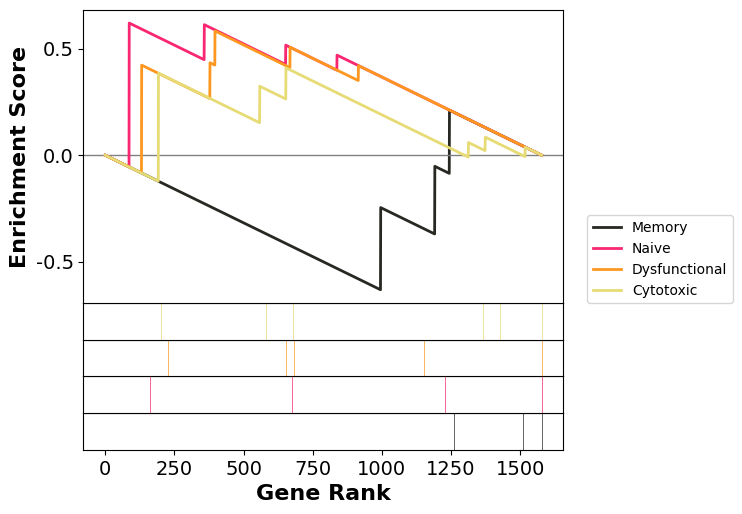

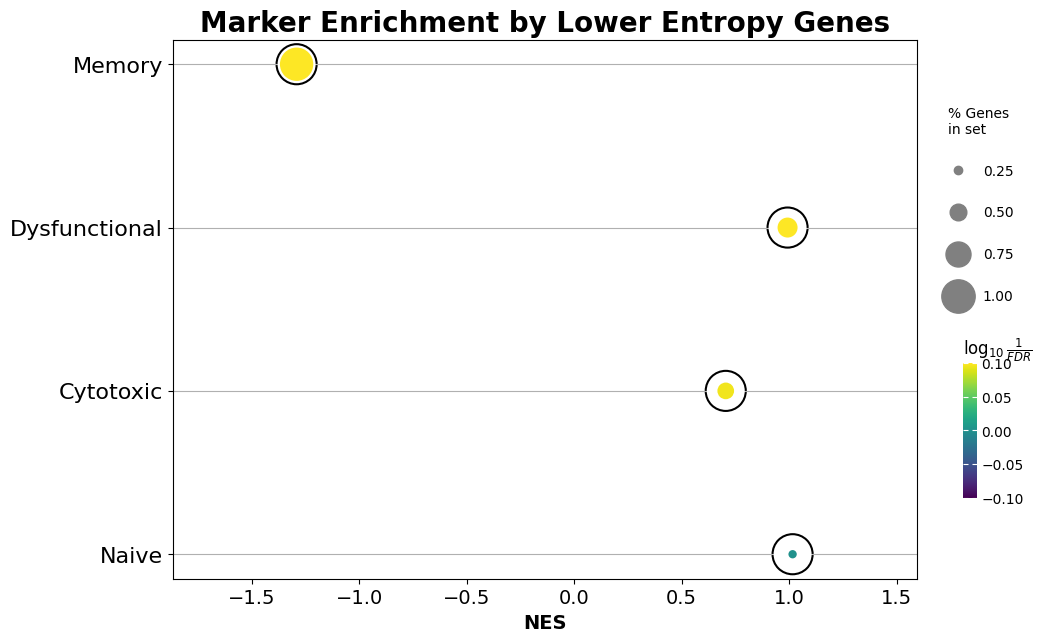

In [42]:
tcri.pl.marker_enrichment_score(adata,markers=markers)
tcri.pl.marker_enrichment_dotplot(adata,markers=markers)

2023-10-24 00:16:06,285 [WARNING] Duplicated values found in preranked stats: 36.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-24 00:16:06,459 [WARNING] Duplicated values found in preranked stats: 36.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-24 00:16:06,626 [WARNING] Duplicated values found in preranked stats: 36.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Cytotoxic,0.798514,1.40865,0.135634,0.476436,0.3185,2/6,8.70%,PRF1;GZMH
1,prerank,Naive,0.840409,1.399926,0.108624,0.252098,0.332,2/4,7.20%,IL7R;SELL
2,prerank,Dysfunctional,0.634571,1.077492,0.409969,0.539488,0.7825,2/5,18.15%,HAVCR2;ENTPD1
3,prerank,Memory,0.634546,1.013931,0.463695,0.469012,0.8445,1/3,10.20%,ZNF683


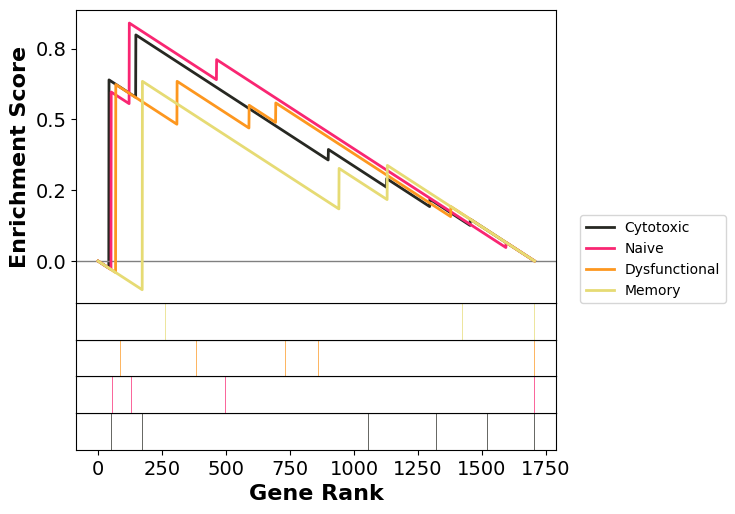

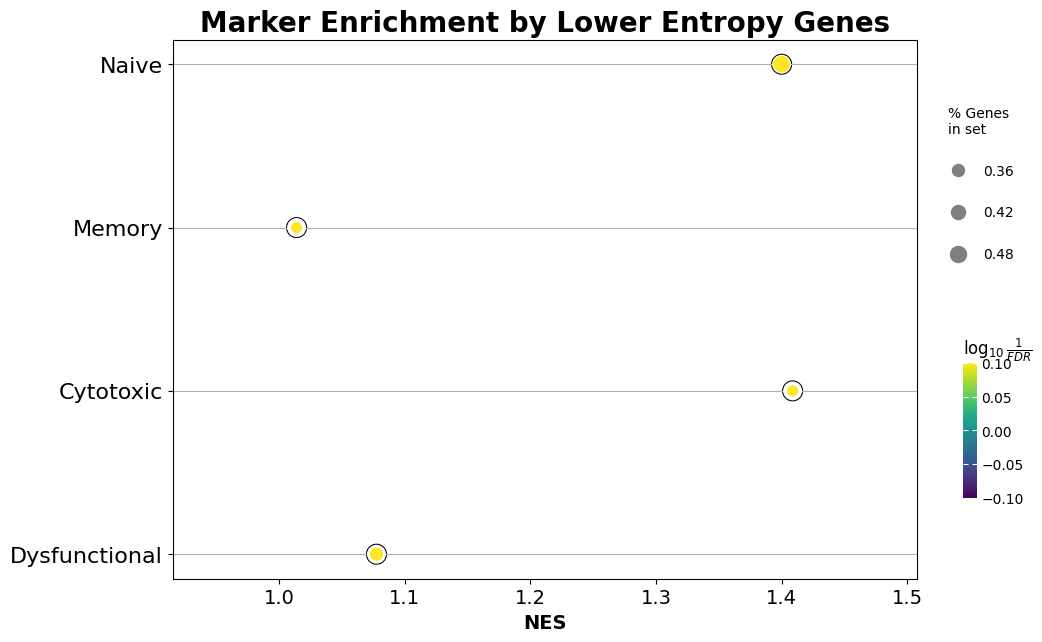

In [43]:
tcri.pl.marker_enrichment_score(responder,markers=markers)
tcri.pl.marker_enrichment_dotplot(responder,markers=markers)
tcri.tl.marker_enrichment(responder,markers=markers).res2d

2023-10-24 00:16:23,182 [WARNING] Duplicated values found in preranked stats: 32.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-24 00:16:23,454 [WARNING] Duplicated values found in preranked stats: 32.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-24 00:16:23,620 [WARNING] Duplicated values found in preranked stats: 32.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Dysfunctional,0.703998,1.222676,0.262797,0.766709,0.5845,1/5,4.75%,TIGIT
1,prerank,Cytotoxic,0.556547,0.989715,0.500875,0.752148,0.8625,5/6,38.55%,PRF1;GZMA;GZMH;GNLY;NKG7
2,prerank,Memory,0.593215,0.964864,0.54039,0.531827,0.8865,2/3,26.55%,ZNF683;CRTAM
3,prerank,Naive,-0.38978,-0.883316,0.607676,0.600233,0.699357,4/4,61.15%,LEF1;SELL;TCF7;IL7R


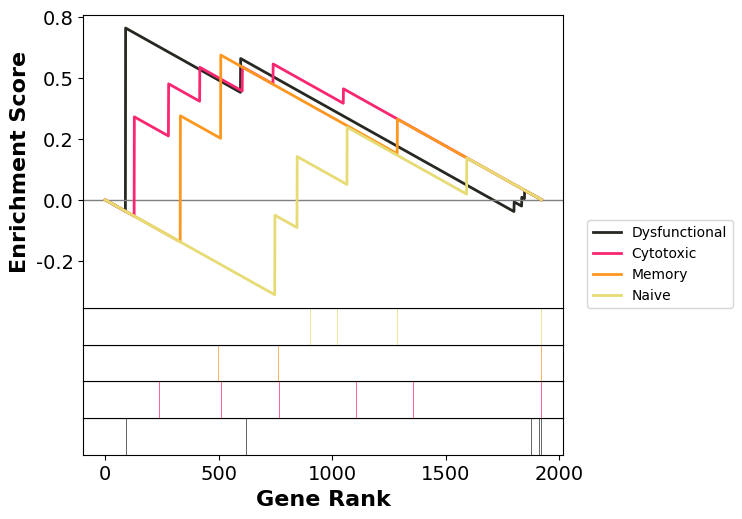

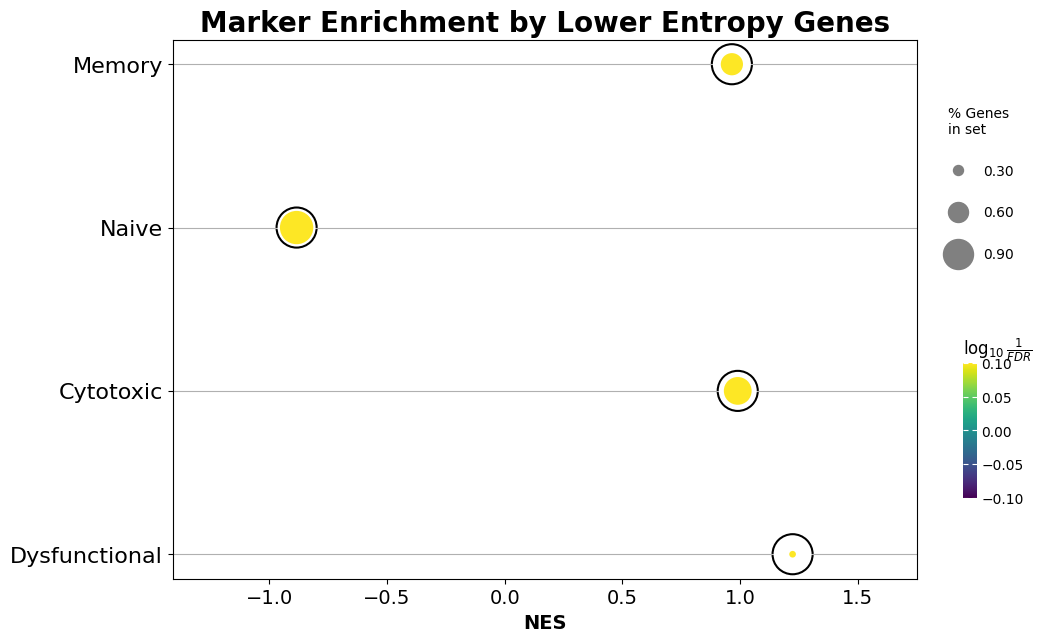

In [44]:
tcri.pl.marker_enrichment_score(nonresponder,markers=markers)
tcri.pl.marker_enrichment_dotplot(nonresponder,markers=markers)
tcri.tl.marker_enrichment(nonresponder,markers=markers).res2d

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dysfunctional_NR v.s. Dysfunctional_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.800e+01
Cytotoxic_NR v.s. Cytotoxic_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Memory_NR v.s. Memory_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.000e+00
Naive_NR v.s. Naive_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


,Gene,Entropy
1990,DOK5,205.0
1991,STAG3,200.0
1992,SOX4,197.0
1993,FBXO5,195.0
1994,IL23R,194.0
1995,KNSTRN,194.0
1996,ATAD2,178.0
1997,CEBPD,178.0
1998,MGST2,168.0
1999,C1QB,163.0


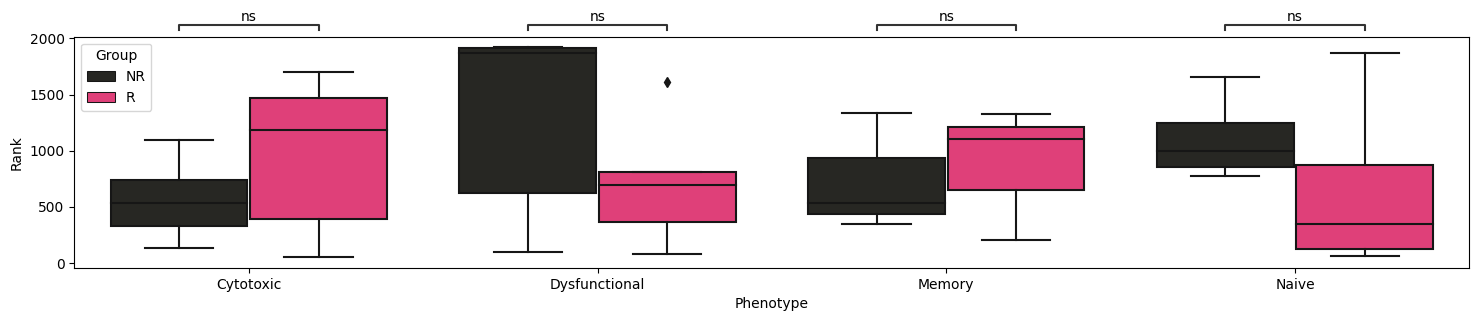

In [45]:
tcri.pp.joint_distribution(adata)
tcri.pl.rank_markers(adata,markers=markers,groupby="response",figsize=(18,3))
tcri.tl.rank_genes_by_clonotypic_entropy(adata).tail(10)

<AxesSubplot: xlabel='Phenotype', ylabel='Entropy'>

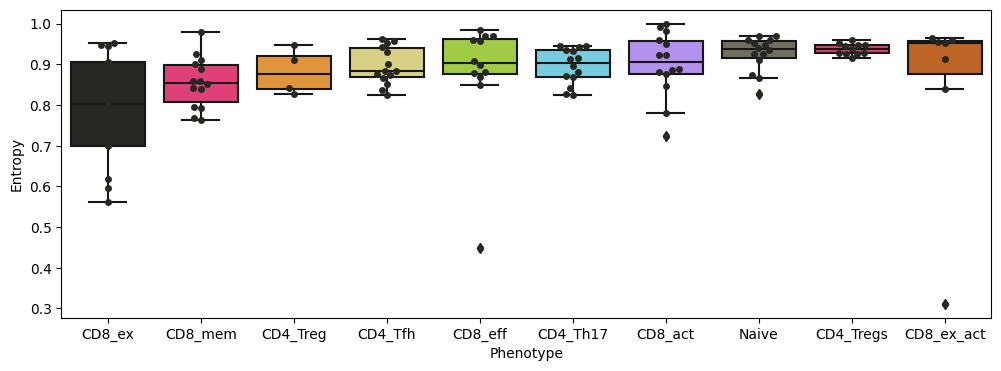

In [46]:
tcri.pl.transcriptional_entropy(adata, phenotype_key="phenotype", groupby="patient", figsize=(12,4))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD8_ex_act_NR v.s. CD8_ex_act_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.714e-01 U_stat=0.000e+00
CD4_Tregs_NR v.s. CD4_Tregs_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
CD8_mem_NR v.s. CD8_mem_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
CD8_ex_NR v.s. CD8_ex_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.200e+01
CD4_Treg_NR v.s. CD4_Treg_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+00
CD8_eff_NR v.s. CD8_eff_R: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
CD4_Th17_NR v.s. CD4_Th17_R: Mann-Whitney-Wilcoxon test two-sided with Bonfe

<AxesSubplot: xlabel='Phenotype', ylabel='Entropy'>

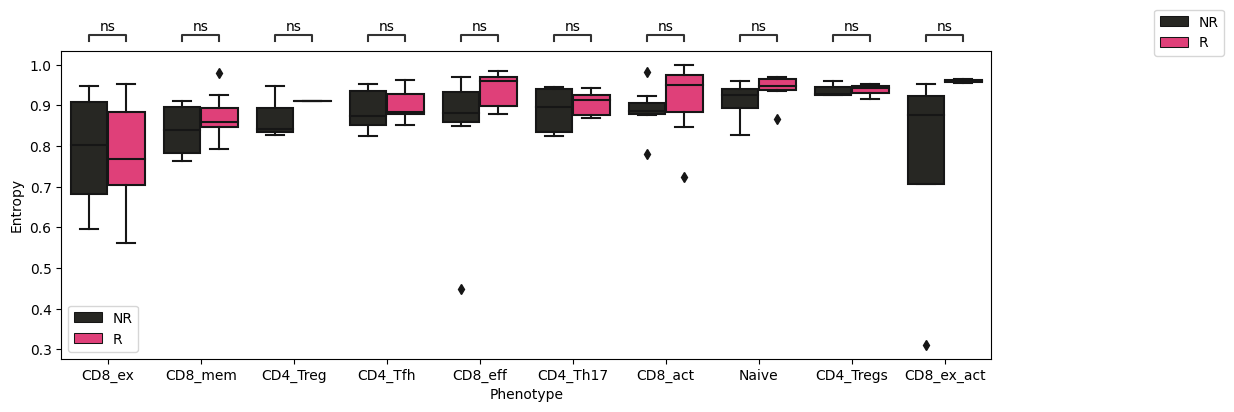

In [47]:
tcri.pl.transcriptional_entropy(adata, phenotype_key="phenotype", groupby="patient", splitby="response", figsize=(12,4))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD4_Tregs_pre v.s. CD4_Tregs_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Naive_pre v.s. Naive_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
CD8_ex_pre v.s. CD8_ex_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.100e+01
CD8_ex_act_pre v.s. CD8_ex_act_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=0.000e+00
CD4_Th17_pre v.s. CD4_Th17_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+01
CD8_eff_pre v.s. CD8_eff_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.400e+01
CD4_Tfh_pre v.s. CD4_Tfh_post: Mann-Whitney-Wilcoxon tes

<AxesSubplot: xlabel='Phenotype', ylabel='Entropy'>

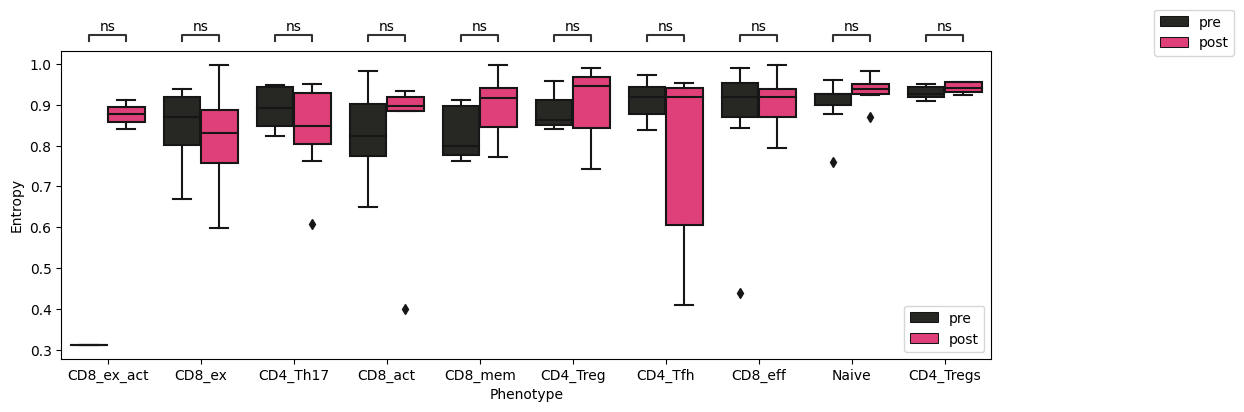

In [48]:

tcri.pl.transcriptional_entropy(nonresponder, phenotype_key="phenotype", groupby="patient", splitby="treatment")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CD8_ex_act_pre v.s. CD8_ex_act_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=0.000e+00
Naive_pre v.s. Naive_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+01
CD8_mem_pre v.s. CD8_mem_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+01
CD8_ex_pre v.s. CD8_ex_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
CD8_act_pre v.s. CD8_act_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.225e-01 U_stat=2.500e+01
CD8_eff_pre v.s. CD8_eff_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.000e+00
CD4_Th17_pre v.s. CD4_Th17_post: Mann-Whitney-Wilcoxon test tw

<AxesSubplot: xlabel='Phenotype', ylabel='Entropy'>

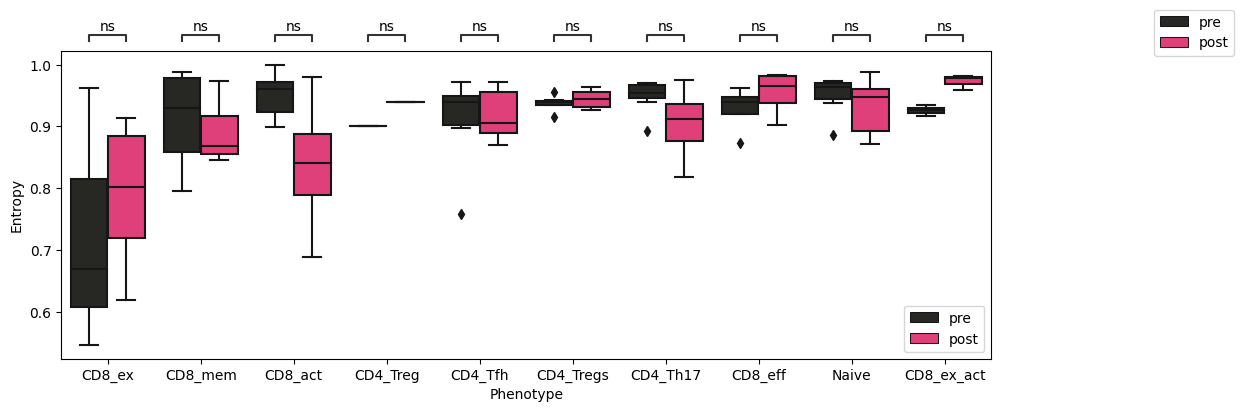

In [49]:
tcri.pl.transcriptional_entropy(responder, phenotype_key="phenotype", groupby="patient", splitby="treatment")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre v.s. post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.015e-01 U_stat=2.300e+01


<AxesSubplot: xlabel='treatment', ylabel='Entropy'>

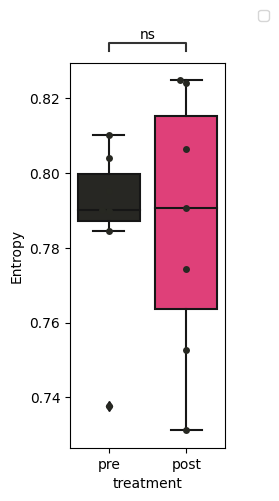

In [50]:
tcri.pl.clonotypic_entropy(responder,groupby="patient",splitby="treatment",figsize=(2,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

post v.s. pre: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.104e-01 U_stat=2.100e+01


<AxesSubplot: xlabel='treatment', ylabel='Entropy'>

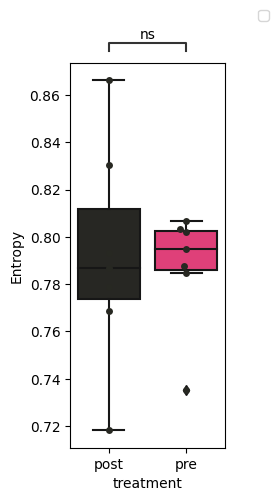

In [51]:
tcri.pl.clonotypic_entropy(nonresponder,groupby="patient",splitby="treatment",figsize=(2,5))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

R v.s. NR: t-test independent samples with Bonferroni correction, P_val=4.644e-02 stat=-2.220e+00


<AxesSubplot: xlabel='Label', ylabel='Flux L1'>

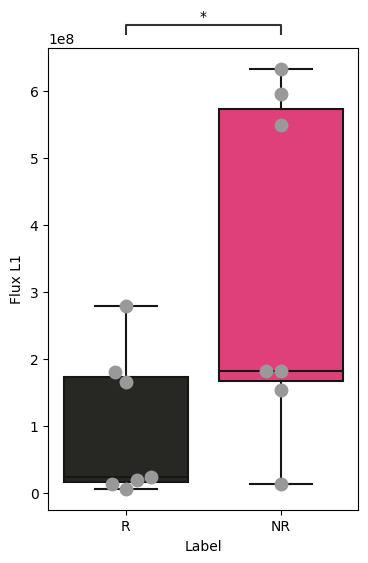

In [52]:
tcri.pl.flux(adata, "treatment", from_this="pre", to_that="post", groupby="patient", splitby="response", figsize=(4,6))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NR v.s. R: t-test independent samples with Bonferroni correction, P_val=nan stat=nan


<AxesSubplot: xlabel='Label', ylabel='Flux dkl'>

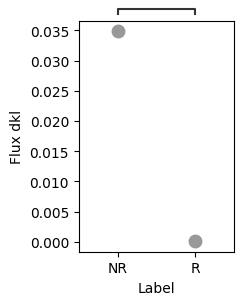

In [53]:
tcri.pl.flux(adata, "treatment", from_this="pre", to_that="post", method="dkl",
             groupby="patient", splitby="response", figsize=(2,3))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

R v.s. NR: t-test independent samples with Bonferroni correction, P_val=3.428e-02 stat=2.388e+00


<AxesSubplot: xlabel='Label', ylabel='MI'>

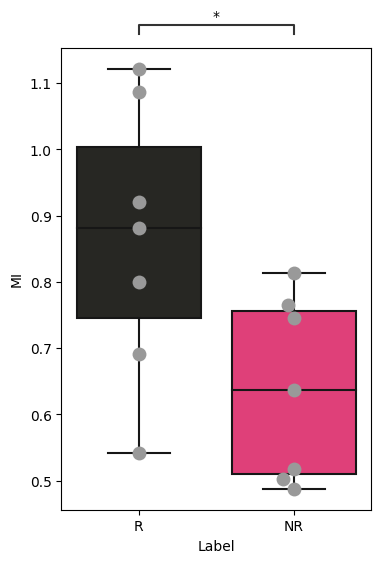

In [54]:
tcri.pl.mutual_information(adata,"patient","response",order=["R",'NR'], figsize=(4,6))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre v.s. post: t-test independent samples with Bonferroni correction, P_val=7.281e-01 stat=3.514e-01


<AxesSubplot: xlabel='Label', ylabel='MI'>

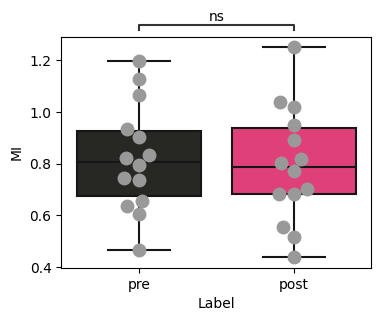

In [55]:
tcri.pl.mutual_information(adata,"patient","treatment",order=["pre","post"], figsize=(4,3))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre v.s. post: t-test independent samples with Bonferroni correction, P_val=3.688e-01 stat=9.338e-01


<AxesSubplot: xlabel='Label', ylabel='MI'>

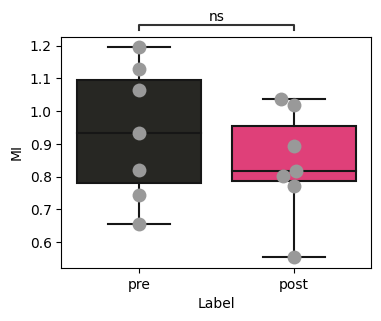

In [56]:
tcri.pl.mutual_information(responder,"patient","treatment", figsize=(4,3),order=["pre","post"])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre v.s. post: t-test independent samples with Bonferroni correction, P_val=7.715e-01 stat=-2.970e-01


<AxesSubplot: xlabel='Label', ylabel='MI'>

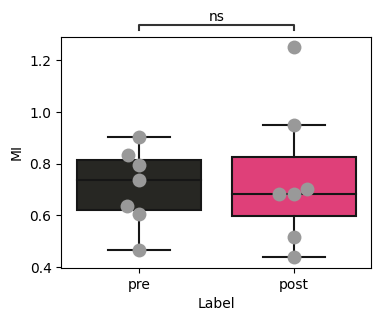

In [57]:
tcri.pl.mutual_information(nonresponder,"patient","treatment",order=["pre","post"], figsize=(4,3))